In [ ]:
import os, json
import pandas as pd
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, context_precision, context_recall, answer_correctness

import sys, os, json
sys.path.append(os.path.abspath("../src"))
from naive_rag import rag, get_or_build_faiss
from enhanced_rag import enhanced_rag
import config
import pandas as pd


os.environ["OPENAI_API_KEY"] = "API-KEY-HERE"  # replace with your key

/Users/shreyajena/Desktop/NLX and LLMs/Assignment2_ShreyaJena/nlx-assignment2-rag/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Setup
config.PASSAGES_PATH = "../data/processed/passages_clean.parquet"
schema, index, embedder = get_or_build_faiss(config.PASSAGES_PATH, config.EMBED_MODEL)

# Load queries
queries = pd.read_parquet(
    "hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet"
).dropna(subset=["question", "answer"])
queries = queries.head(100)

print(f"Building RAGAs JSON for {len(queries)} queries...")

# Build NAIVE RAGAs data
naive_data = []
for idx, row in queries.iterrows():
    q = row["question"]
    gold = row["answer"]
    
    # Get contexts and answer from naive RAG
    contexts_naive, naive_answer = rag(
        q, schema, index, embedder, 
        k=1, style="basic", return_contexts=True
    )
    
    naive_data.append({
        "question": q,
        "answer": naive_answer,
        "contexts": contexts_naive,  # List with 1 passage
        "ground_truth": str(gold)
    })
    
    if (idx + 1) % 20 == 0:
        print(f"  Naive: {idx + 1}/{len(queries)}")

# Build ENHANCED RAGAs data
enhanced_data = []
for idx, row in queries.iterrows():
    q = row["question"]
    gold = row["answer"]
    
    # Get reranked contexts and answer from enhanced RAG
    contexts_enhanced, enhanced_answer = enhanced_rag(
        q, schema, index, embedder, 
        k=3, return_contexts=True
    )
    
    enhanced_data.append({
        "question": q,
        "answer": enhanced_answer,
        "contexts": contexts_enhanced,  # List with 3 reranked passages
        "ground_truth": str(gold)
    })
    
    if (idx + 1) % 20 == 0:
        print(f"  Enhanced: {idx + 1}/{len(queries)}")

# Save to JSON
os.makedirs("../results", exist_ok=True)

with open("../results/naive_ragas.json", "w") as f:
    json.dump(naive_data, f, indent=2)

with open("../results/enhanced_ragas.json", "w") as f:
    json.dump(enhanced_data, f, indent=2)

print(f"\n✓ Saved ../results/naive_ragas.json ({len(naive_data)} queries)")
print(f"✓ Saved ../results/enhanced_ragas.json ({len(enhanced_data)} queries)")

# Quick validation
print("\nSample naive entry:")
print(f"  Question: {naive_data[0]['question']}")
print(f"  Contexts: {len(naive_data[0]['contexts'])} passages")
print(f"  Answer: {naive_data[0]['answer']}")

print("\nSample enhanced entry:")
print(f"  Question: {enhanced_data[0]['question']}")
print(f"  Contexts: {len(enhanced_data[0]['contexts'])} passages")
print(f"  Answer: {enhanced_data[0]['answer']}")

Reloaded FAISS index with 3196 passages
Building RAGAs JSON for 100 queries...
  Naive: 40/100
  Naive: 140/100
  Naive: 200/100
  Naive: 220/100
  Enhanced: 40/100
  Enhanced: 140/100
  Enhanced: 200/100
  Enhanced: 220/100

✓ Saved ../results/naive_ragas.json (100 queries)
✓ Saved ../results/enhanced_ragas.json (100 queries)

Sample naive entry:
  Question: Was Abraham Lincoln the sixteenth President of the United States?
  Contexts: 1 passages
  Answer: yes

Sample enhanced entry:
  Question: Was Abraham Lincoln the sixteenth President of the United States?
  Contexts: 3 passages
  Answer: No


In [4]:

# Evaluate both systems with RAGAs
def run_ragas_eval(path):
    data = json.load(open(path))
    ds = Dataset.from_list(data)
    results = evaluate(
        dataset=ds,
        metrics=[faithfulness, context_precision, context_recall, answer_correctness]
    )
    return results

print("🔹 Running RAGAs on Naive RAG...")
naive_scores = run_ragas_eval("../results/naive_ragas.json")
print("\n🔹 Running RAGAs on Enhanced RAG...")
enhanced_scores = run_ragas_eval("../results/enhanced_ragas.json")

print("\n===== RAGAs Evaluation Results =====")
print("Naive:", naive_scores)
print("Enhanced:", enhanced_scores)


🔹 Running RAGAs on Naive RAG...


Evaluating: 100%|██████████| 400/400 [05:54<00:00,  1.13it/s]



🔹 Running RAGAs on Enhanced RAG...


Evaluating: 100%|██████████| 400/400 [06:42<00:00,  1.01s/it]



===== RAGAs Evaluation Results =====
Naive: {'faithfulness': 0.5354, 'context_precision': 0.5900, 'context_recall': 0.4800, 'answer_correctness': 0.6883}
Enhanced: {'faithfulness': 0.6255, 'context_precision': 0.6850, 'context_recall': 0.5500, 'answer_correctness': 0.5213}


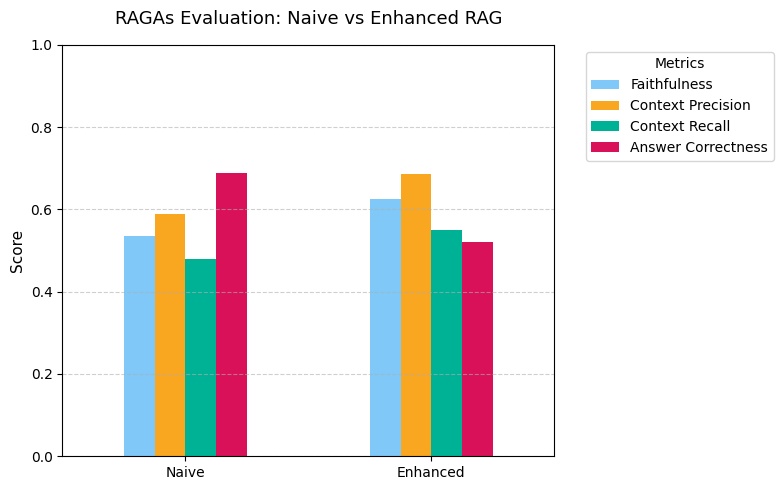

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === RAGAs scores ===
naive_scores = {
    "faithfulness": 0.5354,
    "context_precision": 0.5900,
    "context_recall": 0.4800,
    "answer_correctness": 0.6883
}

enhanced_scores = {
    "faithfulness": 0.6255,
    "context_precision": 0.6850,
    "context_recall": 0.5500,
    "answer_correctness": 0.5213
}

# === Build DataFrame ===
df = pd.DataFrame([
    ["Naive", naive_scores["faithfulness"], naive_scores["context_precision"], naive_scores["context_recall"], naive_scores["answer_correctness"]],
    ["Enhanced", enhanced_scores["faithfulness"], enhanced_scores["context_precision"], enhanced_scores["context_recall"], enhanced_scores["answer_correctness"]],
], columns=["System", "Faithfulness", "Context Precision", "Context Recall", "Answer Correctness"])

# === Plot ===
ax = df.set_index("System").plot(
    kind="bar",
    figsize=(8,5),
    ylim=(0,1),
    rot=0,
    color=["#7fc8f8", "#f9a620", "#00b295", "#d81159"]
)

plt.title("RAGAs Evaluation: Naive vs Enhanced RAG", fontsize=13, pad=15)
plt.ylabel("Score", fontsize=11)
plt.xlabel("")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
